In [1]:
import environ

env = environ.Env()
environ.Env.read_env()
#Todo only load the repo folder
DataSetsPath     = env('DataSetsPath')     #* get the path of the script
ModelsPath       = env('ModelsPath')       #* get the path of the script
fitToolsPath     = env('fitToolsPath')     #* get the path of the script
TestNotebooks    = env('TestNotebooks')    #* get the path of the script   
dataPreparation  = env('dataPreparation')  #* get the path of the script
model_save_dir   = env('model_save_dir')   #* get the path w\here we will save the model
DataSet_Brain_MRI_segmentation   = env('DataSet_Brain_MRI_segmentation')   #* get the path where we will save the model
newFoldersPath   =   env('newFoldersPath')


import sys
sys.path.append(DataSetsPath)
sys.path.append(ModelsPath)
sys.path.append(fitToolsPath)
sys.path.append(TestNotebooks)
sys.path.append(dataPreparation)


import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ", device)

device =  cuda


In [2]:
image_Height   = 252
image_Width    = 252

outPutimage_Height = 68
outPutimage_Width  = 68

image_Channels = 3
batch_size     = 16

In [3]:
import importlib
import dataPreparation.brain_MRI_segmentation_preparation 
importlib.reload(dataPreparation.brain_MRI_segmentation_preparation)
from dataPreparation.brain_MRI_segmentation_preparation import preparation_brain_MRI_Set

preparation_brain_MRI_Set(DataSet_Brain_MRI_segmentation, newFoldersPath)

In [4]:
from DataSets.dataSet_Img_Vs_Img import DataSet_Img_To_Img
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler


inputResize = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Resize((image_Height, image_Width)),  # Resize the image
    transforms.Grayscale(num_output_channels = image_Channels),  # Convert to black and white
    transforms.ToTensor(),  # Convert to tensor
])


outPutResize = transforms.Compose([
                        #* Compose = compoues a list of function
                        transforms.ToPILImage(),
                        transforms.Resize((outPutimage_Height, outPutimage_Width)),
                        # transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
                                        
                        #* ToPILImage = cahnge the data type from PyTorch tensor or a NumPy ndarray to : A PIL (Python Imaging Library)
                        # transforms.RandomVerticalFlip(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomRotation(degrees=15),  
                        transforms.ToTensor(), 
                        #* change the data type from Numpy or PIL to tensor
                        ])

root_Data            = [newFoldersPath + "/train/img", newFoldersPath + "/train/mask"]
root_Data_Validation = [newFoldersPath + "/validation/img", newFoldersPath + "/validation/mask"]

myDataSet            = DataSet_Img_To_Img(root_Data, transfor_In_img = inputResize, transfor_Out_img = outPutResize, test = False, dataSize = 100)
myDataSetValidation  = DataSet_Img_To_Img(root_Data_Validation, transfor_In_img = inputResize, transfor_Out_img = outPutResize, test = False, dataSize = 100)


Size data set lower definition 3929
Size data set lower definition 785


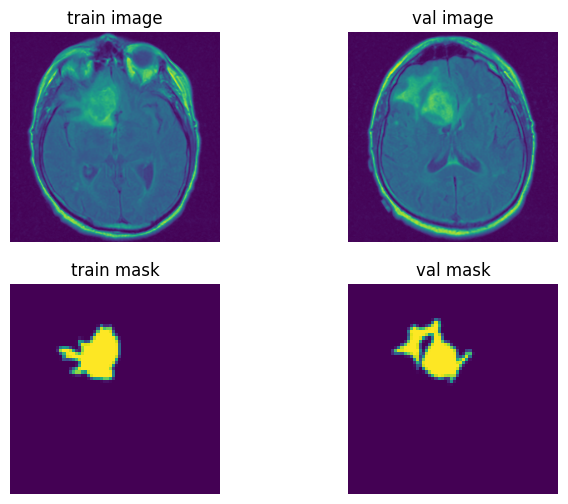

In [5]:
import matplotlib.pyplot as plt
from TestNotebooks.toolsTest import plot_img_tensor

index = 3
fig, (plt1, plt2) = plt.subplots(2, 2, figsize=(8, 6))
plot_img_tensor(myDataSet.__getitem__(index=index)[0], plot_channels = [0], title = "train image", localplt = (fig, plt1[0]))
plot_img_tensor(myDataSet.__getitem__(index=index)[1], plot_channels = [0], title = "train mask" , localplt = (fig, plt2[0]))
plot_img_tensor(myDataSetValidation.__getitem__(index=index)[0], plot_channels = [0], title = "val image", localplt = (fig, plt1[1]))
plot_img_tensor(myDataSetValidation.__getitem__(index=index)[1], plot_channels = [0], title = "val mask" , localplt = (fig, plt2[1]))
plt.show()



In [6]:
import importlib
import Models.model_U_Net
importlib.reload(Models.model_U_Net)
from Models.model_U_Net import model_u_Net

myModel = model_u_Net(in_CHANNELS = 3)
myModel.to(device = device)
print(myModel)

model_u_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): SiLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): SiLU()
  )
  (maxPol1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): SiLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): SiLU()
  )
  (maxPol2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): SiLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): SiLU()
  )
  (ma

In [7]:
import importlib

import fitTools.fitFunctions_superResolution
importlib.reload(fitTools.fitFunctions_superResolution)
from fitTools.fitFunctions_superResolution import fiterU_Net

import torch.nn as nn
from torch import optim
import torch.nn.functional as F


trainerModel = fiterU_Net(myModel, 
                        myDataSet, 
                        device      = device,
                        batch_size  = batch_size,
                        dataSet_Val = myDataSetValidation,
                        model_save_dir =  model_save_dir)


In [8]:

#TODO add gradiente decent with adjustable step size
# opt_model = optim.Adam(myModel.parameters(), lr = 0.0001)
opt_model = torch.optim.SGD(myModel.parameters(),
                                lr = 0.001,
                                momentum=0.95,
                                weight_decay=1e-4
                            )

# criterion  = nn.BCEWithLogitsLoss()
criterion  = torch.nn.CrossEntropyLoss()

trainerModel.trainModel(opt_model  = opt_model,
                        criterion  = criterion,
                        num_epochs = 10,
                        getValMAE  = True)
#* best 0.3203

  0%|          | 0/246 [00:00<?, ?it/s]C:\Users\malekir1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1/10 process: 99: 100%|██████████| 246/246 [01:32<00:00,  2.66it/s, modelLoss=0.504]


Epoch completed, TRAIN MAE 0.5767
Epoch completed, VAL MAE: 0.513393


Epoch 2/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.64it/s, modelLoss=0.407]


Epoch completed, TRAIN MAE 0.4461
Epoch completed, VAL MAE: 0.410728


Epoch 3/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.57it/s, modelLoss=0.368]


Epoch completed, TRAIN MAE 0.3796
Epoch completed, VAL MAE: 0.370772


Epoch 4/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.61it/s, modelLoss=0.345]


Epoch completed, TRAIN MAE 0.3545
Epoch completed, VAL MAE: 0.354482


Epoch 5/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.61it/s, modelLoss=0.335]


Epoch completed, TRAIN MAE 0.3401
Epoch completed, VAL MAE: 0.341822


Epoch 6/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.60it/s, modelLoss=0.34] 


Epoch completed, TRAIN MAE 0.3329
Epoch completed, VAL MAE: 0.337215


Epoch 7/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.60it/s, modelLoss=0.329]


Epoch completed, TRAIN MAE 0.3291
Epoch completed, VAL MAE: 0.334485


Epoch 8/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.60it/s, modelLoss=0.321]


Epoch completed, TRAIN MAE 0.3268
Epoch completed, VAL MAE: 0.332385


Epoch 9/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.62it/s, modelLoss=0.323]


Epoch completed, TRAIN MAE 0.3252
Epoch completed, VAL MAE: 0.331060


Epoch 10/10 process: 99: 100%|██████████| 246/246 [01:08<00:00,  3.60it/s, modelLoss=0.325]


Epoch completed, TRAIN MAE 0.3240
Epoch completed, VAL MAE: 0.329761


In [30]:

# imgInput, imgOutPut = trainerModel.getDataBatch(0)

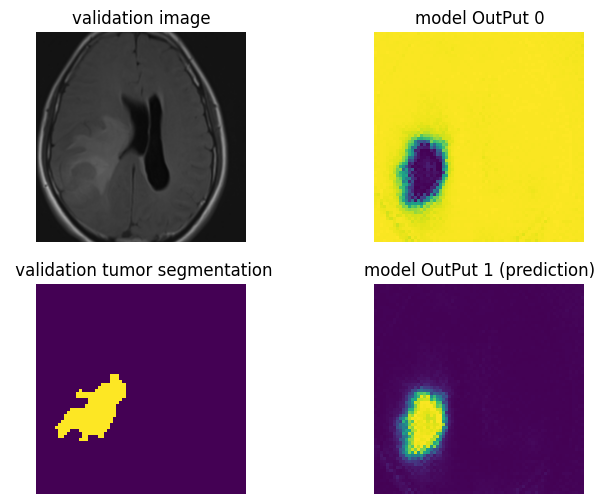

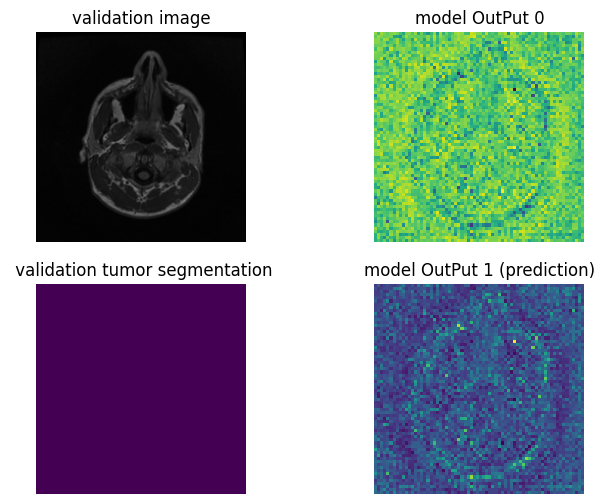

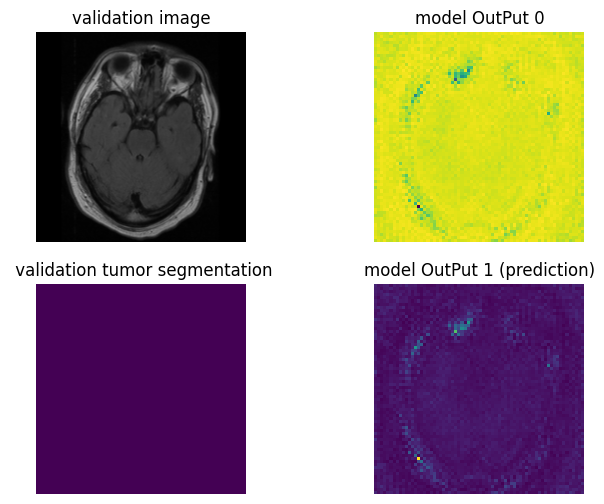

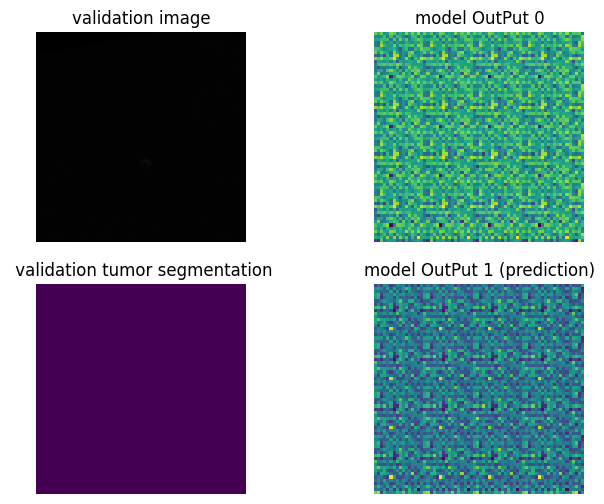

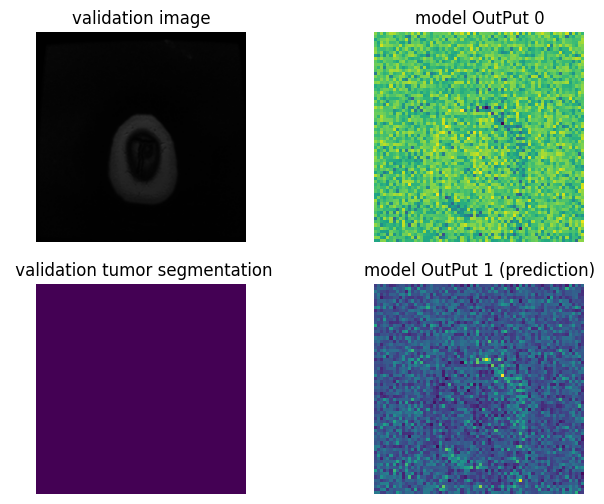

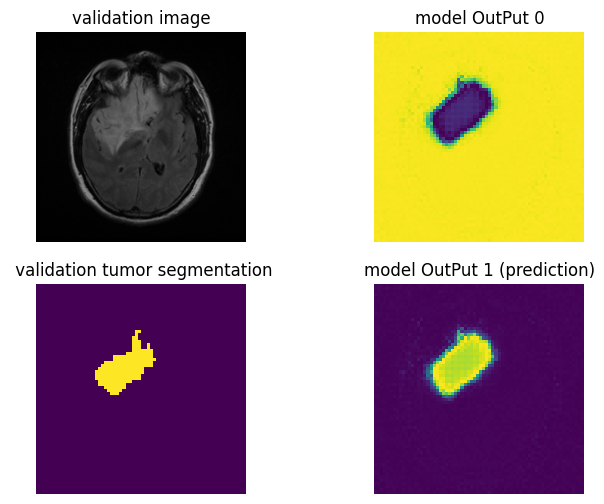

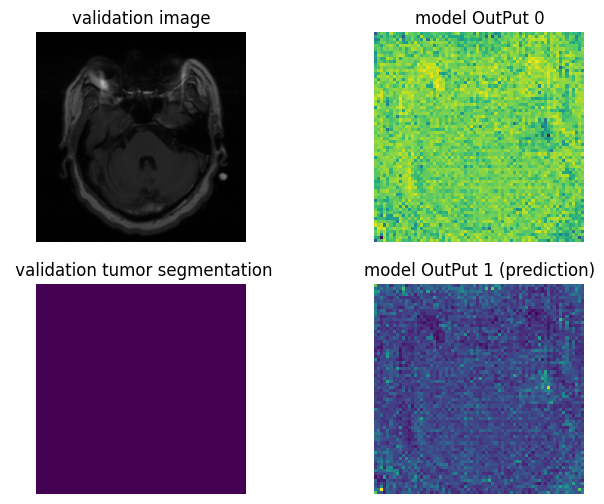

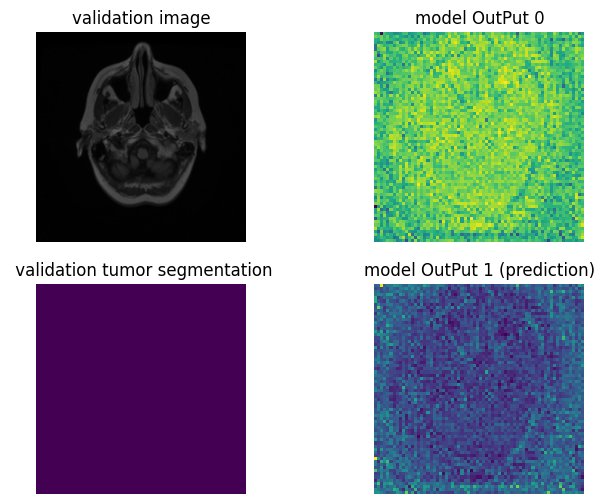

In [65]:
for i in range(8):
    index = 2
    for idx, (imgInput, imgOutPut) in enumerate(trainerModel.data_loader_Val):
        if idx == index:
            #*take  (imgInput, imgOutPut) = data_loader[index]
            break


    imgInput    = imgInput.to(device)
    imgOutPut   = imgOutPut.to(device, torch.long)
    modelOutPut = myModel(imgInput)
    imgOutPut   = imgOutPut

    fig, (plt1, plt2) = plt.subplots(2, 2, figsize=(8, 6))
    plot_img_tensor(   imgInput[0], [0, 1, 2], title = "validation image", localplt = (fig, plt1[0]))
    plot_img_tensor(  imgOutPut[0], [0], title = " validation tumor segmentation", localplt = (fig, plt2[0]))
    plot_img_tensor(modelOutPut[0], [0], title = "model OutPut 0", localplt = (fig, plt1[1]))
    plot_img_tensor(modelOutPut[0], [1], title = "model OutPut 1 (prediction)", localplt = (fig, plt2[1]))

    plt.show()



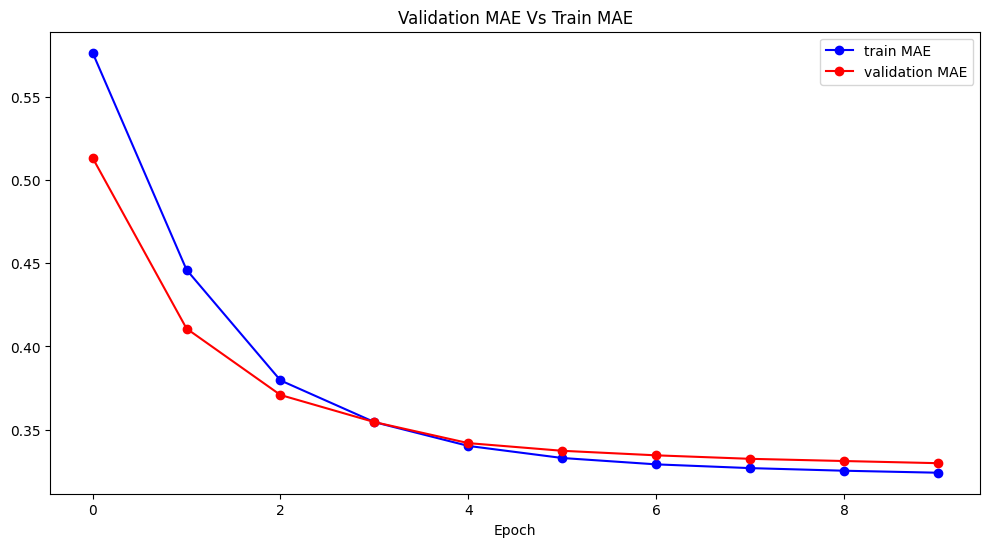

In [66]:
trainerModel.printHistorial()